In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
from skimpy import clean_columns
import contextily as cx
import requests

In [133]:
# pandas display options
pd.options.display.float_format = '{:.4f}'.format

## Read in Data

In [106]:
# LA County Census Tracts and SVI 
svi = gpd.read_file('Data/svi_tracts.geojson')

# LACoFD station locations
lacofd_stations = gpd.read_file('Data/LACoFD_stations.geojson')

# LACoFD station boundaries
lacofd_station_bounds = gpd.read_file('Data/LACoFD_station_boundaries.geojson')

# LAFD station locations
lafd_stations = gpd.read_file('Data/lafd_stations.geojson')

# LAFD station boundaries
lafd_station_bounds = gpd.read_file('Data/lafd_station_boundaries.geojson')

# all fire stations serving LA county
all_stations = gpd.read_file('Data/all_stations.geojson')

In [107]:
# LA county boundary (useful for plotting)
url = 'https://maps.lacity.org/lahub/rest/services/Boundaries/MapServer/15/query?outFields=*&where=1%3D1&f=geojson'
data = requests.get(url)
county_bound = gpd.GeoDataFrame.from_features(data.json())

# set crs
county_bound = county_bound.set_crs('EPSG:4326')

In [138]:
# set crs
svi = svi.to_crs('EPSG:2229')
lacofd_stations = lacofd_stations.to_crs('EPSG:2229')
lacofd_station_bounds = lacofd_station_bounds.to_crs('EPSG:2229')
lafd_stations = lafd_stations.to_crs('EPSG:2229')
lafd_station_bounds = lafd_station_bounds.to_crs('EPSG:2229')
all_stations = all_stations.to_crs('EPSG:2229')

In [139]:
# area of each census tract in feet
svi['area'] = svi['geometry'].area

In [140]:
# LACoFD station bound areas
lacofd_station_bounds['area'] = lacofd_station_bounds['geometry'].area

In [141]:
# LAFD station bound areas
lafd_station_bounds['area'] = lafd_station_bounds['geometry'].area

In [137]:
svi['area'].describe()

count          2496.0000
mean       45881580.3721
std       426638902.7671
min          494204.6354
25%         5912935.4886
50%        10343026.9538
75%        18492006.0138
max     16085090333.1979
Name: area, dtype: float64

In [142]:
lacofd_station_bounds['area'].describe()

count          174.0000
mean     521483773.9595
std     1159991037.3034
min       14159278.9287
25%       87644255.2254
50%      134325953.7776
75%      320525084.2502
max     7866423536.5044
Name: area, dtype: float64

In [143]:
lafd_station_bounds['area'].describe()

count         106.0000
mean    126412210.6374
std      80421085.3665
min      16209563.8498
25%      72647481.2343
50%     108316268.3156
75%     143934349.6662
max     418013194.9243
Name: area, dtype: float64

In [144]:
svi['centroid'] = svi['geometry'].centroid

In [156]:
sindex = svi.sindex

In [158]:
# 
stations_in_tracts = gpd.sjoin(all_stations, svi, how = 'inner', predicate = 'within')

In [160]:
station_count_by_tract = stations_in_tracts.groupby('tract').agg(
    station_count = ('index_right', 'count')
).reset_index()

In [162]:
station_count_by_tract = svi.merge(
    station_count_by_tract, on = 'tract', how = 'left'
).fillna({'station_count': 0})

In [165]:
station_count_by_tract = gpd.GeoDataFrame(station_count_by_tract, geometry = 'geometry', crs = svi.crs)

In [168]:
lacofd_station_bounds['contains_tract'] = lacofd_station_bounds['geometry'].apply(
    lambda stanum: svi['geometry'].apply(
        lambda tract: stanum.contains(tract)
    ).any()
)

<Axes: >

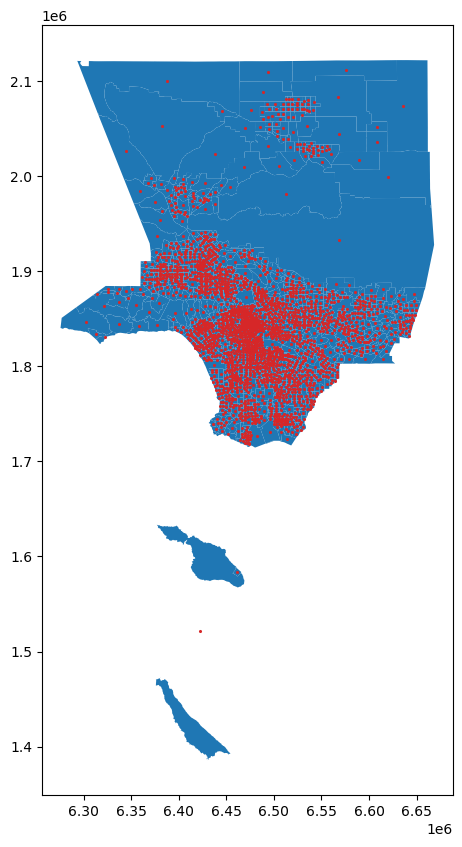

In [150]:
ax = svi.plot(figsize = (12, 10))
svi['centroid'].plot(ax = ax, color = 'C3', markersize = 1.5)

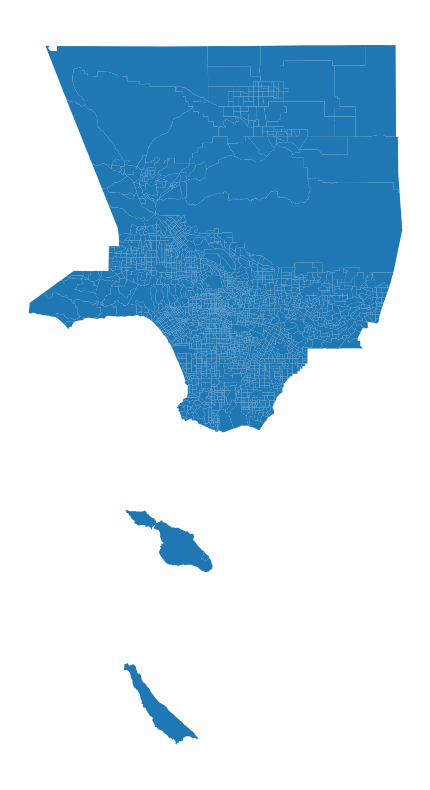

In [108]:
ax = svi.to_crs('EPSG:2229').plot(figsize = (12, 10), linewidth = 0.3)
plt.axis('off');

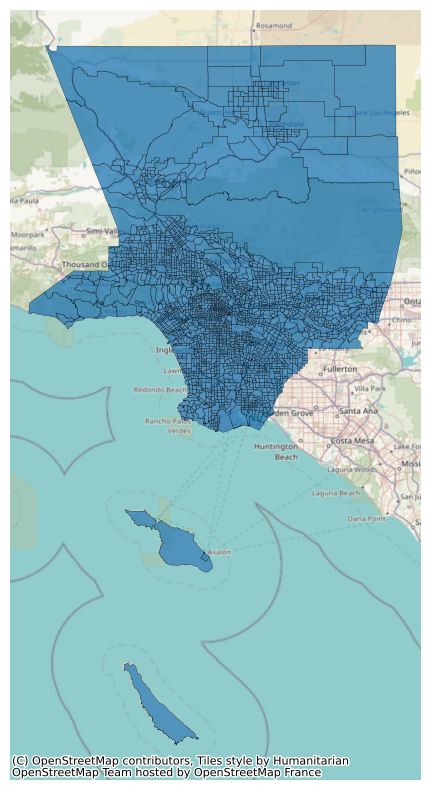

In [119]:
ax = svi.to_crs('EPSG:2229').plot(figsize = (12, 10), edgecolor = 'black', linewidth = 0.25, alpha = 0.75)

contextily.add_basemap(ax, crs = 'EPSG:2229')
plt.axis('off');

In [111]:
all_stations['department_2'] = np.where(all_stations['department'].isin(['LACoFD', 'LAFD']), all_stations['department'], 'Other')

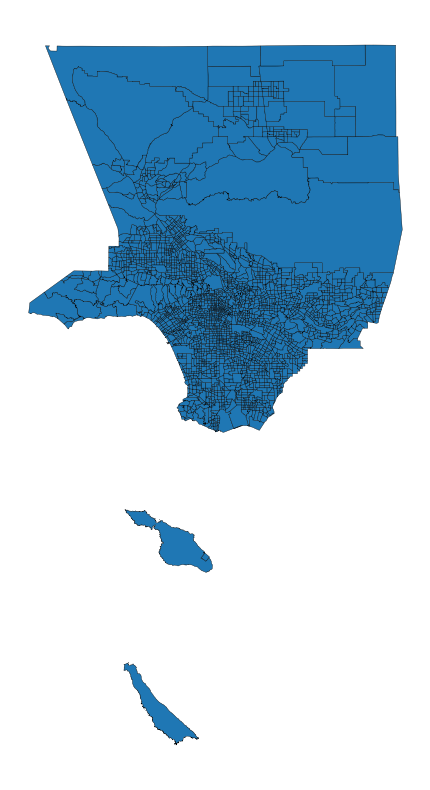

In [122]:
ax = svi.to_crs('EPSG:2229').plot(figsize = (12, 10), linewidth = 0.25, edgecolor = 'k')
plt.axis('off');

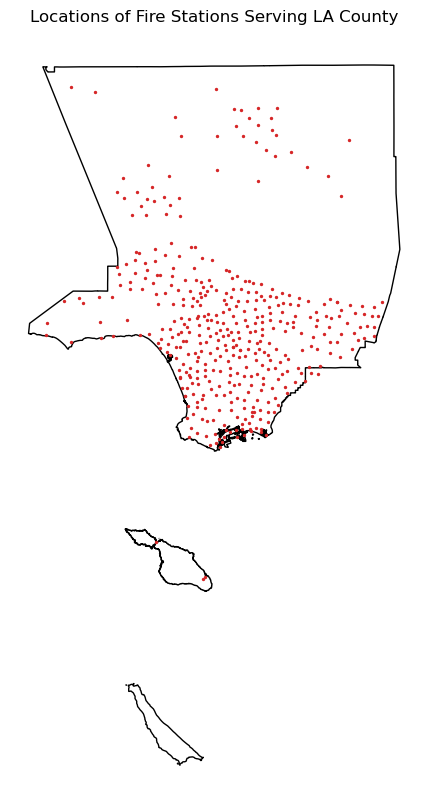

In [124]:
ax = county_bound.plot(figsize = (12, 10), color = 'white', edgecolor = 'k')
all_stations.plot(ax = ax, markersize = 2, color = 'C3', marker = 'o', legend = True)
ax.set(title = 'Locations of Fire Stations Serving LA County')
plt.axis('off');

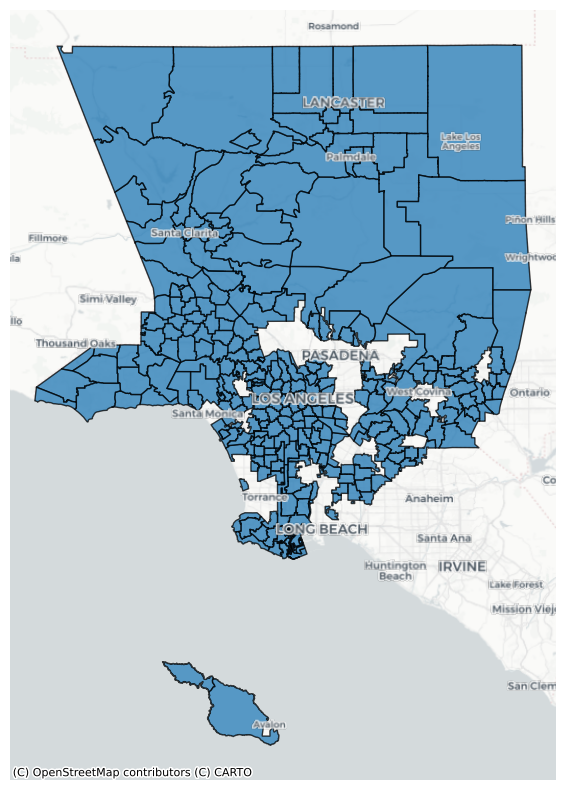

In [87]:
union_bounds = lacofd_station_bounds.overlay(lafd_station_bounds, how = 'union')
ax = union_bounds.to_crs('EPSG:2229').plot(figsize = (12, 10), alpha = 0.75, edgecolor = 'k')
cx.add_basemap(ax, crs = 'EPSG:2229', source=cx.providers.CartoDB.PositronNoLabels)
cx.add_basemap(ax, crs = 'EPSG:2229', source=cx.providers.CartoDB.PositronOnlyLabels)
ax.set_axis_off()

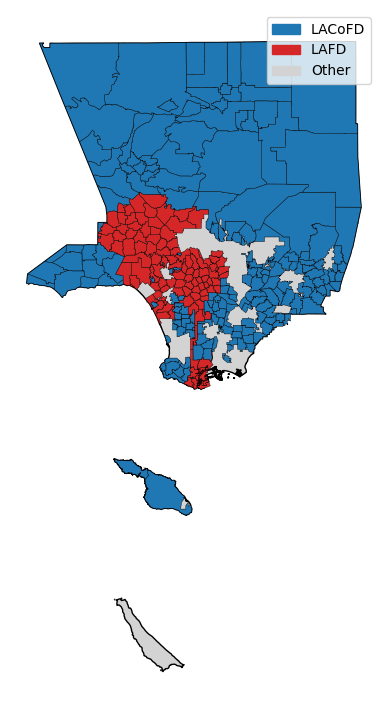

In [ ]:
# Station boundaries
fig, ax = plt.subplots(figsize = (11, 9))
county_bound.plot(ax = ax, color = 'lightgray', edgecolor = 'black')
lacofd_bounds.plot(
    ax = ax,
    edgecolor = 'black',
    linewidth = 0.3
)
lafd_bounds.plot(
    ax = ax,
    color = 'C3',
    edgecolor = 'black',
    linewidth = 0.3
)
ax.set_axis_off()
blue_patch = mpatches.Patch(color = 'C0', label = 'LACoFD')
red_patch = mpatches.Patch(color = 'C3', label = 'LAFD')
gray_patch = mpatches.Patch(color = 'lightgray', label = 'Other')
ax.legend(handles = [blue_patch, red_patch, gray_patch])
plt.savefig('fig4', bbox_inches = 'tight', dpi = 600)